## Import Necessary Libraries

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
from urllib.parse import quote
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Import libraries for the model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.notebook import trange
from sklearn.metrics import mean_squared_error, r2_score

## Set path for saving model training results
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed
seed_val = 77
set_seed(seed_val)

cuda


## Selecting Data Columns
* Tag names are loaded in sequential order.
* The process of selecting the required tag names from the tag name list.

In [2]:
# Function to display tag names
def show_column(URL):
    
    # Load tag name data
    df = pd.read_csv(URL)
    
    # Convert to list format
    df = df.values.reshape(-1)
    
    return df.tolist()

In [3]:
## Set parameters for displaying tag names
table = 'appliance_energy'

NAME_URL = f'http://127.0.0.1:5654/db/tql/datahub/api/v1/get_tag_names.tql?table={table}'

## Generate tag name list
name = show_column(NAME_URL)

In [4]:
name

['Appliances',
 'Press_mm_hg',
 'RH_1',
 'RH_2',
 'RH_3',
 'RH_4',
 'RH_5',
 'RH_6',
 'RH_7',
 'RH_8',
 'RH_9',
 'RH_out',
 'T1',
 'T2',
 'T3',
 'T4',
 'T5',
 'T6',
 'T7',
 'T8',
 'T9',
 'T_out',
 'Tdewpoint',
 'Visibility',
 'Windspeed',
 'lights',
 'rv1',
 'rv2']

## Converting TAG Name Format
* After checking all the Tag Names from the Appliances Energy dataset in the previous step, extract only the columns to be used and convert them into parameter format.
* Use Appliances tag name

In [5]:
# Set the desired tag names
tags = name[:1]

# Wrap each item in the list with single quotes and separate with commas
tags_ = ",".join(f"'{tag}'" for tag in tags)

# Check the selected tag names
print(tags_)

'Appliances'


## Load Appliances Energy Dataset
* Load the data using all tag name

In [6]:
# Data loading parameter settings

# Set the tag table name
table = 'appliance_energy'
# Set the tag names
name = quote(tags_, safe=":/")
# Set the time format 
timeformat = 'default'
# Set the data start time
start_time = quote('2016-01-11 17:00:00')
# Set the data end time
end_time = quote('2016-05-27 18:00:00')

In [7]:
# Data loading function
def data_load(table, name, start_time, end_time, timeformat):
    
    # Load data 
    df = pd.read_csv(f'http://127.0.0.1:5654/db/tql/datahub/api/v1/select-rawdata.tql?table={table}&name={name}&start={start_time}&end={end_time}&timeformat={timeformat}')

    # Convert to data grouped by the time
    df = df.pivot_table(index='TIME', columns='NAME', values='VALUE', aggfunc='first').reset_index()

    # Set TIME column
    df['TIME'] = pd.to_datetime(df['TIME'])
    
    # Set time index
    df.set_index('TIME', inplace=True)
    
    # Time series decomposition
    decomposition = seasonal_decompose(df['Appliances'], model='additive', period=24)

    # Use only the trend
    trend = decomposition.trend 
    
    # Create a new DataFrame
    df = pd.DataFrame(trend.dropna().values, columns=['value'])
    df.index = trend.dropna().index
    
    # Create new columns with window applied
    df['lag1'] = df['value'].shift(1)  # Previous 10-min data
    df['lag2'] = df['value'].shift(2)  # Previous 20-min data
    df['lag3'] = df['value'].shift(3)  # Previous 30-min data 
    df['lag4'] = df['value'].shift(4)  # Previous 40-min data 
    
    # Remove missing values
    df = df.dropna()
    
    # Move 'value' column to the end
    df['value'] = df.pop('value')
  
    return df

In [8]:
# Load data
df = data_load(table, name, start_time, end_time, timeformat)
df

,lag1,lag2,lag3,lag4,value
TIME,,,,,
2016-01-11 19:40:00,139.791667,137.708333,135.625000,133.541667,141.666667
2016-01-11 19:50:00,141.666667,139.791667,137.708333,135.625000,143.541667
2016-01-11 20:00:00,143.541667,141.666667,139.791667,137.708333,145.625000
2016-01-11 20:10:00,145.625000,143.541667,141.666667,139.791667,153.750000
2016-01-11 20:20:00,153.750000,145.625000,143.541667,141.666667,167.916667
...,...,...,...,...,...
2016-05-27 15:20:00,129.791667,139.166667,143.541667,140.625000,122.916667
2016-05-27 15:30:00,122.916667,129.791667,139.166667,143.541667,116.666667
2016-05-27 15:40:00,116.666667,122.916667,129.791667,139.166667,114.375000


In [9]:
# Split the data into train, validation, and test sets
# The training data is set to data before May, and test data is set to May data

train = df[df.index.month < 5]
test = df[df.index.month == 5]

## Data Preprocessing
* 1 Decomposition -> Applied in advance
* 2 Min-Max Scaling

### 2. Applying Min-Max Scaling
* Apply to both input data and target data separately to facilitate conversion back to original values after testing. 

In [10]:
# Set up scalers
scaler_data = MinMaxScaler()
scaler_target = MinMaxScaler()

# Apply scalers
train_ = scaler_data.fit_transform(train.iloc[:, 1:].values)
train_t = scaler_target.fit_transform(train.iloc[:, :1].values)

test_ = scaler_data.transform(test.iloc[:, 1:].values)
test_t = scaler_target.transform(test.iloc[:, :1].values)

# Set each DataFrames
train_scaled = pd.DataFrame(train_)  
train_scaled['Appliances'] = train_t

test_scaled = pd.DataFrame(test_)
test_scaled['Appliances'] = test_t

## Dataset & Loader Setup

### Window Dataset Configuration
* To train on time series data, you need to set the window size and the sliding step.

* Window size: Determines how many time points to group together.
* Step size: The time interval by which the window moves.

In [11]:
# Sliding Window Dataset Configuration
class SlidingWindowDataset(Dataset):
    def __init__(self, data, window_size, step_size):
        self.data = data
        self.window_size = window_size
        self.step_size = step_size
        self.windows, self.targets = self._create_windows()
    
    # Set up sliding windows
    def _create_windows(self):
        windows = []
        targets = []
        for i in range(0, len(self.data) - self.window_size + 1, self.step_size):
            window = self.data.iloc[i:i + self.window_size, :-1].values  # Exclude the last column
            target_array = self.data.iloc[i:i + self.window_size, -1].values  # The last column is the target
                
            windows.append(torch.Tensor(window))
            targets.append(torch.Tensor(target_array))  # Convert target to Tensor
        return windows, targets
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return self.windows[idx], self.targets[idx]

In [12]:
# Sliding window configuration
window_size = 6
step_size = 1

# Set up datasets 
train_ = SlidingWindowDataset(train_scaled, window_size, step_size)
test_ = SlidingWindowDataset(test_scaled, window_size, step_size)

# Set up data loaders
train_dataloader = DataLoader(train_, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_, batch_size=64, shuffle=False)

In [13]:
# Verify DataLoader application and check the shape of the input data
print(list(train_dataloader)[0][0].shape)

torch.Size([64, 6, 4])


## Model Configuration
* Using BILSTM model.

In [14]:
# BILSTM Model Configuration
class BILSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, window_size, dropout=0.2, bidirectional=False):
        super(BILSTM, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout, bidirectional=bidirectional)
        
        self.lstm2 = nn.LSTM(2*hidden_size, 2*hidden_size, num_layers, 
                    batch_first=True, dropout=dropout, bidirectional=bidirectional)
        
        self.fc = nn.Linear(2* hidden_size * (2 if bidirectional else 1), window_size)
        
        # Define Layer normalization layer (using hidden_size)
        self.layer_norm = nn.LayerNorm(2 * hidden_size)  # 2 * hidden_size matches the output size of bidirectional LSTM

    def forward(self, x):
        # LSTM 1 output
        out, (h_n, c_n) = self.lstm1(x)
        
        # Apply LayerNorm
        out = self.layer_norm(out)
        
        # LSTM 2 output
        out, (h_n, c_n) = self.lstm2(out)
        
        # Apply final FC layer
        out = self.fc(out[:, -1, :])
        return out

In [15]:
# Model configuration parameters

# number of input data columns
# last number in print(list(train_dataloader)[0][0].shape)
input_dim = 4

# BILSTM hidden state size
hidden_dim = 64

# layer size
num_layers = 2

# Learning rate
learning_rate = 0.01

# Model configuration
model = BILSTM(input_dim, hidden_dim, num_layers, window_size, bidirectional=True).to(device)

# Configure loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check the model architecture
print(model)

BILSTM(
  (lstm1): LSTM(4, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (lstm2): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=6, bias=True)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
)


## Model Training

* Save the model with the Best Loss based on the validation data during training.

In [16]:
# Initialize loss
train_loss = []
train_loss = []
# Initialize total step
total_step = len(train_dataloader)
# Set number of epochs
epoch_in = trange(100, desc='training')
# Initialize best Loss value
best_Loss= np.inf

# Start model training
for epoch in epoch_in:
    model.to(device)
    model.train()
    running_loss = 0.0

    for batch_idx, train_data in enumerate(train_dataloader):

        inputs = train_data[0].to(device).float()
        target = train_data[1].to(device).float()

        optimizer.zero_grad()
        
        # Input to the model
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs.squeeze(), target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss)}')

    # Save the best model
    if best_Loss > np.mean(train_loss):
        best_Loss = np.mean(train_loss)
        torch.save(model, f'./result/Appliance_Energy_General.pt')
        print('Model saved')
    epoch_in.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")

training:   0%|          | 0/100 [00:00<?, ?it/s]


train loss: 0.03495164750511908
Model saved

train loss: 0.027053462800341224
Model saved

train loss: 0.019258662329303827
Model saved

train loss: 0.01488981059868189
Model saved

train loss: 0.012207129907899855
Model saved

train loss: 0.01038484159441948
Model saved

train loss: 0.009041915369329329
Model saved

train loss: 0.00801786201274612
Model saved

train loss: 0.007211217850442161
Model saved

train loss: 0.0065750911590234575
Model saved

train loss: 0.00618532180507047
Model saved

train loss: 0.005814765212076333
Model saved

train loss: 0.005425066628470925
Model saved

train loss: 0.005112332591394613
Model saved

train loss: 0.004863453117657625
Model saved

train loss: 0.004609951260660916
Model saved

train loss: 0.004384177519056367
Model saved

train loss: 0.004178639586036197
Model saved

train loss: 0.003993638348465927
Model saved

train loss: 0.0038339666980604656
Model saved

train loss: 0.003686792523590362
Model saved

train loss: 0.003551895486576914
Mod

## Model Testing

In [21]:
# Load the best model
model_ = torch.load(f'./result/Appliance_Energy_General.pt')

In [22]:
# Initial settings 
output_test = []
target_test = []

with torch.no_grad():
    model_.eval()
    running_loss_t = 0.0
    
    for batch_idx, test_data in enumerate(test_dataloader):
        
        inputs_t = test_data[0].to(device).float()
        target_t = test_data[1].to(device).float()

        outputs_t = model_(inputs_t)
        
        output_test.append(outputs_t)
        target_test.append(target_t)
        
# Combine tensors into one
combined_tensor_target = torch.cat(target_test, dim=0)
combined_tensor_pred = torch.cat(output_test, dim=0)

# Use only the last value of the window
last_values_target = combined_tensor_target[:, -1].cpu()
last_values_pred = combined_tensor_pred[:, -1].cpu()

# Inverse transform using MinMaxScaler 
real_values = scaler_target.inverse_transform(last_values_target.numpy().reshape(-1, 1))
real_pred_values = scaler_target.inverse_transform(last_values_pred.numpy().reshape(-1, 1))

## Model Performance Evaluation

In [23]:
# Calculate MSE
mse = mean_squared_error(real_values, real_pred_values)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(real_values, real_pred_values)
print("R² Score:", r2)

Mean Squared Error: 133.03603
R² Score: 0.9540596304571456


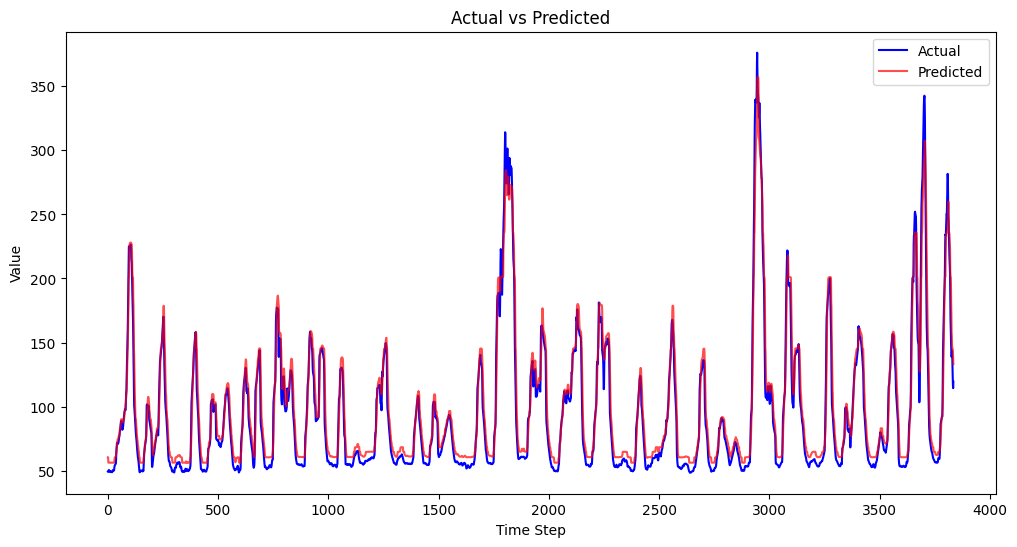

In [24]:
# Compare the test results: Actual values vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(real_values, label='Actual', color='blue')
plt.plot(real_pred_values, label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()